<a href="https://colab.research.google.com/github/danielsoy/ADer/blob/main/trae_effi_b5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import time

Parameters that need to be defined before the choice<br>
Add max images parameter at the top with other parameters

In [2]:
IMG_SIZE = 224
EPOCHS = 30
MAX_IMAGES = 1000  # Limit number of images to load

Modify load_data function

In [3]:
def load_data():
    images = []
    for filename in os.listdir(DATA_PATH)[:MAX_IMAGES]:  # Limit images
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(DATA_PATH, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype('float32') / 255.
            images.append(img)
            if len(images) >= MAX_IMAGES:  # Double check limit
                break
    return np.array(images)
SAVE_PATH = ''
DATA_PATH = ''
BATCH_SIZE = 16

Set environment (1: Local CPU, 2: Colab GPU)

In [4]:
choice = "2"  # Hardcoded choice for local CPU training

In [5]:
if choice == "2":
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = '/content/drive/MyDrive/good'
    SAVE_PATH = '/content/drive/MyDrive'
else:
    DATA_PATH = 'c:\\Users\\libro\\OneDrive\\Escritorio\\treads\\good'
    SAVE_PATH = 'c:\\Users\\libro\\OneDrive\\Escritorio\\treads'
    BATCH_SIZE = 8  # Smaller batch size for CPU
    tf.config.set_soft_device_placement(True)
def create_model():
    # Base EfficientNetB5 model
    base_model = EfficientNetB5(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Partial fine-tuning: unfreeze last layers
    base_model.trainable = True
    for layer in base_model.layers[:-30]:  # Freeze all except last 30 layers
        layer.trainable = False

    # Create encoder-decoder architecture
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs)

    # Encoder additional layers with dropout for better generalization
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)  # Add dropout to prevent overfitting
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    encoded = layers.Dense(512, activation='relu', name='encoder_output')(x)

    # Decoder layers
    x = layers.Dense(1024, activation='relu')(encoded)
    x = layers.Dense(IMG_SIZE * IMG_SIZE * 3, activation='sigmoid')(x)
    outputs = layers.Reshape((IMG_SIZE, IMG_SIZE, 3))(x)

    return Model(inputs, outputs)
# Remove the first load_data function and keep only this version
def load_data():
    images = []
    file_list = sorted(os.listdir(DATA_PATH))[:MAX_IMAGES]  # Limit and sort files
    print(f"Loading up to {MAX_IMAGES} images...")

    for filename in file_list:
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(DATA_PATH, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype('float32') / 255.
            images.append(img)
            if len(images) >= MAX_IMAGES:
                break

    print(f"Actually loaded: {len(images)} images")
    return np.array(images)
# Set up GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Mounted at /content/drive


Load data

In [6]:
print("Loading data...")
x_train = load_data()
print(f"Loaded {len(x_train)} images")

Loading data...
Loading up to 1000 images...
Actually loaded: 1000 images
Loaded 1000 images


After setting DATA_PATH and SAVE_PATH, add:

In [7]:
checkpoint_dir = os.path.join(SAVE_PATH, 'checkpoints')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

Create and compile model

In [8]:
model = create_model()
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Add callbacks with fixed path

In [9]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(
        os.path.join(checkpoint_dir, 'model_{epoch:02d}.keras'),
        save_best_only=True,
        monitor='val_loss'
    ),
    TensorBoard(log_dir=os.path.join(SAVE_PATH, 'logs/fit/' + time.strftime('%Y%m%d-%H%M%S')))
]

Modified training section

In [10]:
history = model.fit(
    x_train,
    x_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - loss: 0.0778 - mae: 0.1841 - val_loss: 0.0112 - val_mae: 0.0397
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 138ms/step - loss: 0.0103 - mae: 0.0432 - val_loss: 0.0115 - val_mae: 0.0386
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 52s 891ms/step - loss: 0.0101 - mae: 0.0423 - val_loss: 0.0106 - val_mae: 0.0411
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 147ms/step - loss: 0.0099 - mae: 0.0424 - val_loss: 0.0111 - val_mae: 0.0404
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - loss: 0.0101 - mae: 0.0432 - val_loss: 0.0112 - val_mae: 0.0565
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 0.0099 - mae: 0.0434 - val_loss: 0.0106 - val_mae: 0.0464
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - loss: 0.0097 - mae: 0.0420 - val_loss: 0.0108 - val_mae: 0.0531
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - loss: 0.0098 - mae: 0.0428 - val_loss: 0.0114 - val_mae: 0.0434
Epoch 9/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - 

Add training visualization

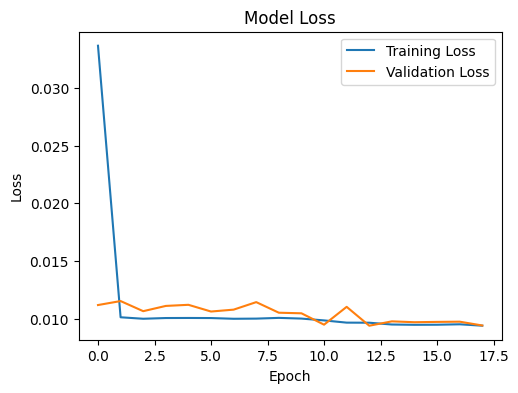

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

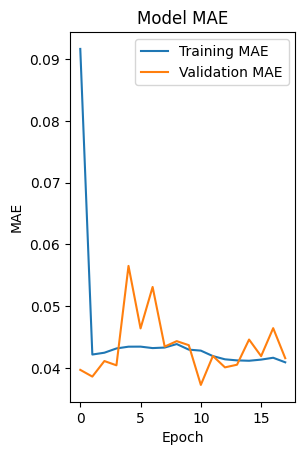

In [12]:
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

In [13]:
plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, 'training_metrics.png'))
plt.close()

Save model and history<br>
Modified save paths

In [23]:
model.save(os.path.join(SAVE_PATH, 'efficientnet_anomaly_model.keras'))
np.save(os.path.join(SAVE_PATH, 'training_history.npy'), history.history)

In [15]:
print("Training completed and model saved!")

Training completed and model saved!
